In [1]:
# Import Libraries
import time
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from lightfm import LightFM
from lightfm.datasets import fetch_movielens
from lightfm.evaluation import auc_score
from lightfm.evaluation import precision_at_k

In [2]:
# Fetch Movielens Data
movielens = fetch_movielens()
movielens

{'train': <943x1682 sparse matrix of type '<class 'numpy.int32'>'
 	with 90570 stored elements in COOrdinate format>,
 'test': <943x1682 sparse matrix of type '<class 'numpy.int32'>'
 	with 9430 stored elements in COOrdinate format>,
 'item_features': <1682x1682 sparse matrix of type '<class 'numpy.float32'>'
 	with 1682 stored elements in Compressed Sparse Row format>,
 'item_feature_labels': array(['T', 'G', 'F', ..., 'S', 'Y', 'S'], dtype='<U1'),
 'item_labels': array(['T', 'G', 'F', ..., 'S', 'Y', 'S'], dtype='<U1')}

In [3]:
train, test = movielens['train'], movielens['test']

In [4]:
# Setting global variables
alpha = 1e-05
epochs = 100
num_components = 32
threads = 8

In [5]:
# Analysing AUC and P@K scores for epochs

# LighFM WARP mode
# max_sampled to set to low value to decrease fitting time over epochs
warp_model = LightFM(no_components=num_components,
                    loss='warp',
                    max_sampled=3,
                    user_alpha=alpha,
                    item_alpha=alpha)

bpr_model = LightFM(no_components=num_components,
                    loss='bpr',
                    user_alpha=alpha,
                    item_alpha=alpha)

warp_duration = []
bpr_duration = []
warp_auc = []
bpr_auc = []
warp_pk = []
bpr_pk = []

for epoch in range(epochs):
    start = time.time()
    warp_model.fit_partial(train, epochs=1, num_threads=threads)
    warp_duration.append(time.time() - start)
    warp_auc.append(auc_score(warp_model, test, train_interactions=train).mean())
    warp_pk.append(precision_at_k(warp_model, test, train_interactions=train).mean())

for epoch in range(epochs):
    start = time.time()
    bpr_model.fit_partial(train, epochs=1, num_threads=threads)
    bpr_duration.append(time.time() - start)
    bpr_auc.append(auc_score(bpr_model, test, train_interactions=train).mean())
    bpr_pk.append(precision_at_k(bpr_model, test, train_interactions=train).mean())

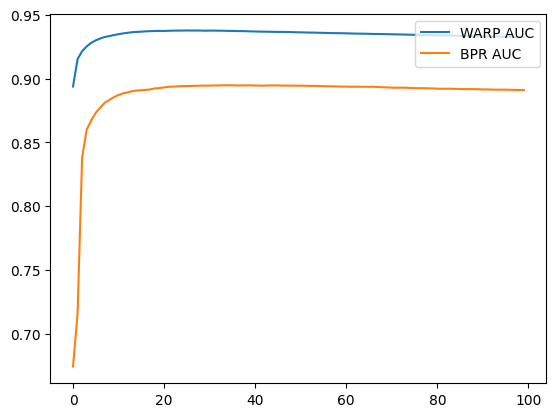

In [6]:
# Plotting AUC Score
x = np.arange(epochs)
plt.plot(x, np.array(warp_auc))
plt.plot(x, np.array(bpr_auc))
plt.legend(['WARP AUC', 'BPR AUC'], loc='upper right')
plt.show()

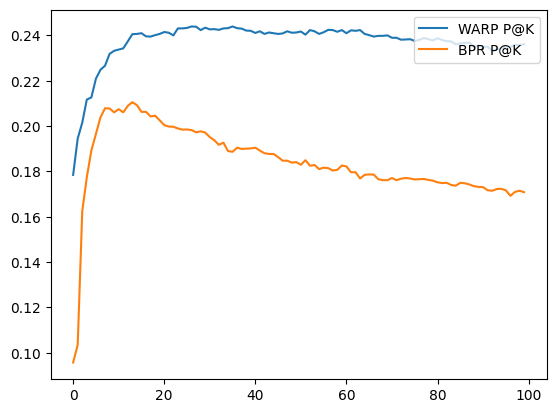

In [7]:
# Plotting P@K Score
x = np.arange(epochs)
plt.plot(x, np.array(warp_pk))
plt.plot(x, np.array(bpr_pk))
plt.legend(['WARP P@K', 'BPR P@K'], loc='upper right')
plt.show()

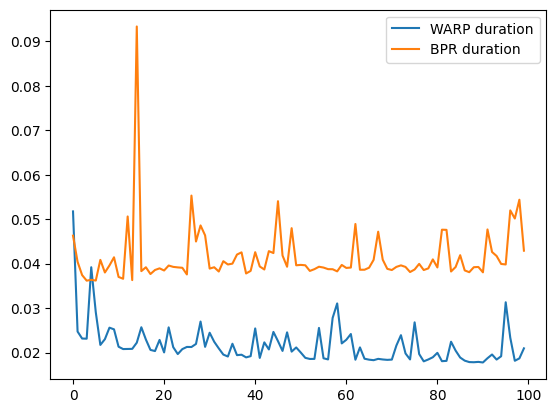

In [8]:
# Plotting Model Fit Duration
x = np.arange(epochs)
plt.plot(x, np.array(warp_duration))
plt.plot(x, np.array(bpr_duration))
plt.legend(['WARP duration', 'BPR duration'], loc='upper right')
plt.show()

In [9]:
# Model Fitting on BPR loss
model = LightFM(loss='bpr')

model.fit(train, epochs=20, num_threads=threads, verbose=True)

train_precision = precision_at_k(model, train, num_threads=threads).mean()

# Train Interactions are passed in model testing to avoid recommending known positives
test_precision = precision_at_k(model, test, train_interactions=train, num_threads=threads).mean()

train_auc = auc_score(model, train, num_threads=threads).mean()
test_auc = auc_score(model, test, train_interactions=train, num_threads=threads).mean()

print('Precision: train %.2f, test %.2f.' % (train_precision, test_precision))
print('AUC: train %.2f, test %.2f.' % (train_auc, test_auc))

Epoch: 100%|██████████| 20/20 [00:00<00:00, 27.36it/s]


Precision: train 0.60, test 0.19.
AUC: train 0.91, test 0.89.


In [10]:
# Model Fitting on WARP loss
model = LightFM(loss='warp')

# model.fit_partial(train, epochs=20, num_threads=threads, verbose=True)
model.fit(train, epochs=20, num_threads=threads, verbose=True)

train_precision = precision_at_k(model, train, num_threads=threads).mean()
test_precision = precision_at_k(model, test, train_interactions=train, num_threads=threads).mean()

train_auc = auc_score(model, train, num_threads=threads).mean()
test_auc = auc_score(model, test, train_interactions=train, num_threads=threads).mean()

print('Precision: train %.2f, test %.2f.' % (train_precision, test_precision))
print('AUC: train %.2f, test %.2f.' % (train_auc, test_auc))

Epoch: 100%|██████████| 20/20 [00:00<00:00, 31.86it/s]


Precision: train 0.63, test 0.23.
AUC: train 0.94, test 0.93.


In [11]:
# To evaluate if model is doing worse than random, set bias to 0; compute and compare scores
model.item_biases *= 0.0

test_precision = precision_at_k(model, test, train_interactions=train, num_threads=threads).mean()
test_auc = auc_score(model, test, train_interactions=train, num_threads=threads).mean()

print('Precision: test %.2f.' % (test_precision))
print('AUC: test %.2f.' % (test_auc))

Precision: test 0.16.
AUC: test 0.90.


In [12]:
# Hybrid Model by including item features
model = LightFM(loss='warp')

model.fit(train, item_features = movielens['item_features'], epochs=20, num_threads=threads, verbose=True)

train_precision = precision_at_k(model, train, item_features = movielens['item_features'], num_threads=threads).mean()
test_precision = precision_at_k(model, test, train_interactions=train, item_features = movielens['item_features'], num_threads=threads).mean()

train_auc = auc_score(model, train, item_features = movielens['item_features'], num_threads=threads).mean()
test_auc = auc_score(model, test, train_interactions=train, item_features = movielens['item_features'], num_threads=threads).mean()

print('Precision: train %.2f, test %.2f.' % (train_precision, test_precision))
print('AUC: train %.2f, test %.2f.' % (train_auc, test_auc))

Epoch: 100%|██████████| 20/20 [00:00<00:00, 27.61it/s]


Precision: train 0.63, test 0.23.
AUC: train 0.94, test 0.93.


In [13]:
# Comparing Model with and without features
warp_f_model = LightFM(no_components=num_components,
                    loss='warp',
                    max_sampled=3,
                    user_alpha=alpha,
                    item_alpha=alpha)

# warp_model = LightFM(no_components=num_components,
#                     loss='warp',
#                     max_sampled=3,
#                     user_alpha=alpha,
#                     item_alpha=alpha)

warp_f_duration = []
warp_f_auc = []
warp_f_pk = []
# warp_duration = []
# warp_auc = []
# warp_pk = []

for epoch in range(epochs):
    start = time.time()
    warp_f_model.fit_partial(train, item_features = movielens['item_features'], epochs=1, num_threads=threads)
    warp_f_duration.append(time.time() - start)
    warp_f_auc.append(auc_score(warp_f_model, test, train_interactions=train, item_features = movielens['item_features'], num_threads=threads).mean())
    warp_f_pk.append(precision_at_k(warp_f_model, test, train_interactions=train, item_features = movielens['item_features'], num_threads=threads).mean())

# for epoch in range(epochs):
#     start = time.time()
#     warp_model.fit_partial(train, epochs=1, num_threads=threads)
#     warp_duration.append(time.time() - start)
#     warp_auc.append(auc_score(warp_model, test, train_interactions=train).mean())
#     warp_pk.append(precision_at_k(warp_model, test, train_interactions=train).mean())

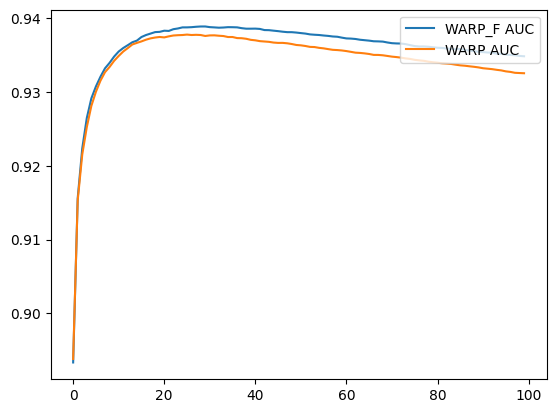

In [14]:
x = np.arange(epochs)
plt.plot(x, np.array(warp_f_auc))
plt.plot(x, np.array(warp_auc))
plt.legend(['WARP_F AUC', 'WARP AUC'], loc='upper right')
plt.show()

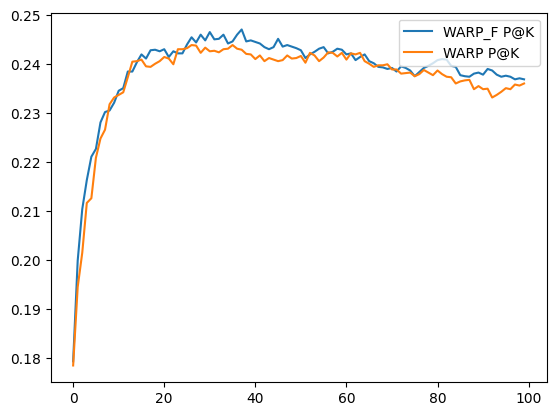

In [15]:
x = np.arange(epochs)
plt.plot(x, np.array(warp_f_pk))
plt.plot(x, np.array(warp_pk))
plt.legend(['WARP_F P@K', 'WARP P@K'], loc='upper right')
plt.show()

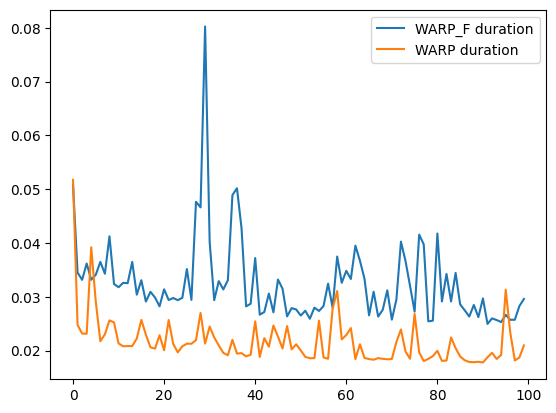

In [16]:
x = np.arange(epochs)
plt.plot(x, np.array(warp_f_duration))
plt.plot(x, np.array(warp_duration))
plt.legend(['WARP_F duration', 'WARP duration'], loc='upper right')
plt.show()

In [17]:
# Getting Recommendations from the Model
def sample_recommendation(model, data, user_ids):
    

    n_users, n_items = data['train'].shape

    for user_id in user_ids:
        known_positives = data['item_labels'][data['train'].tocsr()[user_id].indices]
        
        scores = model.predict(user_id, np.arange(n_items))
        top_items = data['item_labels'][np.argsort(-scores)]
        
        print("User %s" % user_id)
        print("     Known positives:")
        
        for x in known_positives[:3]:
            print("        %s" % x)

        print("     Recommended:")
        
        for x in top_items[:3]:
            print("        %s" % x)
        
sample_recommendation(model, movielens, [3, 25, 450]) 

User 3
     Known positives:
        S
        I
        C
     Recommended:
        S
        A
        C
User 25
     Known positives:
        T
        T
        D
     Recommended:
        S
        F
        R
User 450
     Known positives:
        K
        D
        C
     Recommended:
        G
        D
        C
